In [11]:

import pydicom
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
%matplotlib inline

In [10]:
ids = [
    '00b9585a-9825-4892-8829-ddd75218bd1a.dcm',
    '0e334daf-a272-453d-8d3d-80d9f31d59b7.dcm',
    '0e69231d-bdf2-4a34-ac38-7af04f5848a9.dcm',
    '0f787925-7338-489c-b565-df8a60253141.dcm',
    '0f12250b-7596-4a1e-a1df-dd18aa1f421b.dcm'
]
for image in ids:
    dcm = pydicom.dcmread('..\\rsna-pneumonia-dataset\\stage_2_test_images\\' + image)
    cv2.imwrite('test_images\\' + image.split('.')[0] + '.png', dcm.pixel_array)


In [7]:
cv2.imwrite('img1.png', dcm.pixel_array)

True

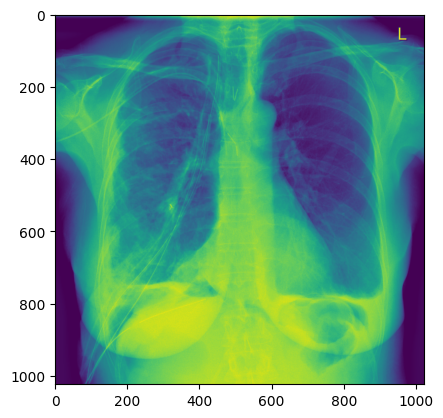

In [5]:
plt.imshow(dcm.pixel_array)

In [7]:
os.listdir('../checkpoint_3_baseline/')

['baseline.md',
 'has_bb.ipynb',
 'is_healthy_metrics.ipynb',
 'logs.csv',
 'md_media',
 'model.ipynb',
 'multiclass_first_experiments.ipynb',
 'pca.pkl',
 'RF_model.pkl',
 'test.ipynb',
 'why_svd.ipynb']

In [8]:
with open('../checkpoint_3_baseline/RF_model.pkl', 'rb') as f:
    model = pickle.load(f)
model

RandomForestClassifier(n_jobs=-1, random_state=74)

Создаем архив, содержащий:

1. Датасет для демонстрации загрузки (архив: картинки и y_train)
2. Датасет для тестов и сравнений моделей (X_test, y_test)
3. Дефолтный датасет для тренировок моделей (X_train, y_train)

In [55]:
import os
import numpy as np
import pandas as pd
import pydicom
import cv2
import random
import shutil
from zipfile import ZipFile
from fastapi_backend.preprocessing import preprocess
import pickle
from sklearn import metrics

# Paths
DICOM_FOLDER = "..\\rsna-pneumonia-dataset\\stage_2_train_images"  # Path to the folder with .dcm files
LABELS_FILE = "..\\rsna-pneumonia-dataset\\stage_2_train_labels.csv"  # Path to the CSV file with labels
DEMO_OUTPUT_FOLDER = "demo_dataset"
DEMO_OUTPUT_ZIP = "demo_dataset.zip"
FOLDER_TO_ZIP = "data"
DEMO_NUM_IMAGES_PER_CLASS = 200

# Create output folders if it doesn't exist
os.makedirs(DEMO_OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FOLDER_TO_ZIP, exist_ok=True)

# Load labels
labels = pd.read_csv(LABELS_FILE)

# Separate by class
class_1 = labels[labels["Target"] == 1]
class_0 = labels[labels["Target"] == 0]

# Randomly sample 200 images from each class
sampled_class_1 = class_1.sample(DEMO_NUM_IMAGES_PER_CLASS * 3, random_state=74)
sampled_class_0 = class_0.sample(DEMO_NUM_IMAGES_PER_CLASS * 3, random_state=74)

demo_sampled_data = pd.concat([
    sampled_class_1[:DEMO_NUM_IMAGES_PER_CLASS],
    sampled_class_0[:DEMO_NUM_IMAGES_PER_CLASS]
    ])
demo_sampled_data = demo_sampled_data.sample(frac=1).reset_index(drop=True)

test_sampled_data = pd.concat([
    sampled_class_1[DEMO_NUM_IMAGES_PER_CLASS:DEMO_NUM_IMAGES_PER_CLASS*2],
    sampled_class_0[DEMO_NUM_IMAGES_PER_CLASS:DEMO_NUM_IMAGES_PER_CLASS*2]
    ])
test_sampled_data = test_sampled_data.sample(frac=1).reset_index(drop=True)

train_sampled_data = pd.concat([
    sampled_class_1[DEMO_NUM_IMAGES_PER_CLASS*2:],
    sampled_class_0[DEMO_NUM_IMAGES_PER_CLASS*2:]
    ])
train_sampled_data = train_sampled_data.sample(frac=1).reset_index(drop=True)

In [56]:
# 1. Датасет для демонстрации загрузки

output_labels = []

for _, row in demo_sampled_data.iterrows():
    patient_id = row["patientId"]
    target = row["Target"]
    
    dicom_path = os.path.join(DICOM_FOLDER, f"{patient_id}.dcm")
    if not os.path.exists(dicom_path):
        print(f"File {dicom_path} not found")
        continue
    
    # Read .dcm file
    dicom_data = pydicom.dcmread(dicom_path)
    image_array = dicom_data.pixel_array
    
    # Normalize and convert to uint8
    image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    
    # Save as .png
    output_image_path = os.path.join(DEMO_OUTPUT_FOLDER, f"{patient_id}.png")
    cv2.imwrite(output_image_path, image_array)
    
    # Append to labels
    output_labels.append({"patientId": patient_id, "Target": target})

# Create labels CSV
demo_output_labels_df = pd.DataFrame(output_labels)
demo_output_labels_csv = os.path.join(DEMO_OUTPUT_FOLDER, "labels.csv")
demo_output_labels_df.to_csv(demo_output_labels_csv, index=False)

# Create a zip archive
with ZipFile(os.path.join(FOLDER_TO_ZIP, DEMO_OUTPUT_ZIP), "w") as zipf:
    for root, _, files in os.walk(DEMO_OUTPUT_FOLDER):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, DEMO_OUTPUT_FOLDER)
            zipf.write(file_path, arcname)


shutil.rmtree(DEMO_OUTPUT_FOLDER)
print(f"Demo dataset prepared and saved to {FOLDER_TO_ZIP}/{DEMO_OUTPUT_ZIP}")

Demo dataset prepared and saved to data/demo_dataset.zip


In [57]:
# 2. Датасет для тестов и сравнений моделей

output_images = []

for _, row in test_sampled_data.iterrows():
    patient_id = row["patientId"]
    target = row["Target"]
    
    dicom_path = os.path.join(DICOM_FOLDER, f"{patient_id}.dcm")
    if not os.path.exists(dicom_path):
        print(f"File {dicom_path} not found.")
        continue
    
    # Read .dcm file
    dcm = pydicom.dcmread(dicom_path)
    output_images.append(cv2.resize(dcm.pixel_array, (128, 128)))

output_images = np.array(output_images)
output_images = preprocess(output_images)
output_labels = test_sampled_data['Target']

pd.DataFrame(output_images).to_csv(os.path.join(FOLDER_TO_ZIP, 'test_images.csv'), index=False)
pd.DataFrame(output_labels).to_csv(os.path.join(FOLDER_TO_ZIP, 'test_labels.csv'), index=False)

print(f"Test dataset prepared and saved to {FOLDER_TO_ZIP}")

Test dataset prepared and saved to data


In [58]:
# 3. Дефолтный датасет для тренировок моделей

output_images = []

for _, row in train_sampled_data.iterrows():
    patient_id = row["patientId"]
    target = row["Target"]
    
    dicom_path = os.path.join(DICOM_FOLDER, f"{patient_id}.dcm")
    if not os.path.exists(dicom_path):
        print(f"File {dicom_path} not found")
        continue
    
    # Read .dcm file
    dcm = pydicom.dcmread(dicom_path)
    output_images.append(cv2.resize(dcm.pixel_array, (128, 128)))

output_images = np.array(output_images)
output_images = preprocess(output_images)
output_labels = train_sampled_data['Target']

pd.DataFrame(output_images).to_csv(os.path.join(FOLDER_TO_ZIP, 'train_images.csv'), index=False)
pd.DataFrame(output_labels).to_csv(os.path.join(FOLDER_TO_ZIP, 'train_labels.csv'), index=False)

print(f"Train dataset prepared and saved to {FOLDER_TO_ZIP}")


Train dataset prepared and saved to data


In [26]:

with open('../checkpoint_3_baseline/RF_model.pkl', 'rb') as pretrained_RF:
    default_RF = pickle.load(pretrained_RF)

X_test = pd.read_csv(os.path.join(FOLDER_TO_ZIP, 'test_images.csv'))
y_test = pd.read_csv(os.path.join(FOLDER_TO_ZIP, 'test_labels.csv'))

pred_proba = default_RF.predict_proba(X_test)[:, 1]
pred = (pred_proba >= 0.5).astype('int')

pred

c:\Users\user\Documents\year_projects\medical_diseases_recognition\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,

In [28]:
from sklearn import metrics

metrics.accuracy_score(y_test, pred), metrics.fbeta_score(y_test, pred, beta=2)

(0.75, np.float64(0.8009708737864077))

In [29]:
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_proba)
roc_auc = metrics.auc(fpr, tpr)

roc_auc

np.float64(0.8147125000000001)

In [59]:
list(fpr)

[np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.005),
 np.float64(0.01),
 np.float64(0.01),
 np.float64(0.015),
 np.float64(0.025),
 np.float64(0.03),
 np.float64(0.03),
 np.float64(0.045),
 np.float64(0.05),
 np.float64(0.055),
 np.float64(0.07),
 np.float64(0.075),
 np.float64(0.08),
 np.float64(0.095),
 np.float64(0.11),
 np.float64(0.125),
 np.float64(0.145),
 np.float64(0.15),
 np.float64(0.15),
 np.float64(0.16),
 np.float64(0.165),
 np.float64(0.175),
 np.float64(0.195),
 np.float64(0.2),
 np.float64(0.22),
 np.float64(0.23),
 np.float64(0.25),
 np.float64(0.27),
 np.float64(0.275),
 np.float64(0.285),
 np.float64(0.305),
 np.float64(0.305),
 np.float64(0.325),
 np.float64(0.35),
 np.float64(0.36),
 np.float64(0.38),
 np.float64(0.4),
 np.float64(0.41),
 np.float64(0.415),
 np.float

In [35]:
float(roc_auc)

0.8147125000000001

In [54]:
de = pd.read_csv('data/train_labels.csv')
np.array(de)
# de

array([[1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
    

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import io
from PIL import Image

fig, ax = plt.subplots( nrows=1, ncols=1 )
# Plot the ROC curve 
ax.plot([1, 2], [1, 2], label='ROC curve ') 
# Roc curve for tpr = fpr  
ax.plot([0, 1], [0, 1], 'k--', label='Random classifier') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC Curve') 
plt.legend(loc="lower right")     
fig.savefig('temp_files\\ROC_Curve.png')  # save the figure to file
plt.close(fig)  # close the figure window

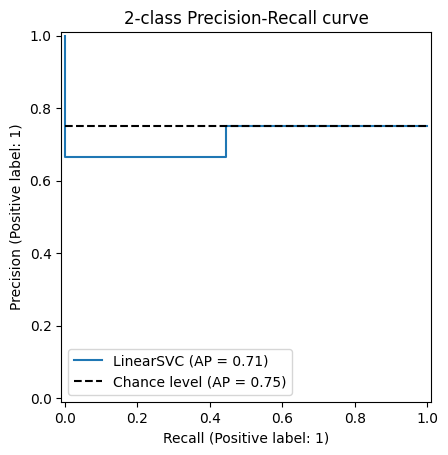

In [55]:
from sklearn.metrics import PrecisionRecallDisplay
y_test = [1,1,0,1,0,1,1,0,1,1,1,1]
y_score = [0,0,0,0,1,1,1,1,1,1,0,0]

display = PrecisionRecallDisplay.from_predictions(
    y_test, y_score, name="LinearSVC", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

plt.savefig('temp_files\\PR_Curve.png')  # save the figure to file
plt.close(fig)  # close the figure window

In [9]:
import pandas as pd

labels = pd.read_csv("../rsna-pneumonia-dataset/stage_2_train_labels.csv")
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [12]:
sum(labels['patientId'] == '0daea621-2fce-4908-9551-0e219d760c7f')

0

In [60]:
import requests

r = requests.get('http://localhost:8012/model_params', params={"model_name": "Pretrained RandomForest"})
r

<Response [200]>

In [64]:
r.json()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 74,
 'verbose': 0,
 'warm_start': False}

In [85]:
np.random.randint(1, 6)

1